In [111]:
import pandas as pd
import os.path as op
from os import sep
import nibabel as nb
import numpy as np
import json
import trimesh
import open3d as o3d
import open3d.visualization.rendering as rendering
import matplotlib.pylab as plt
from matplotlib import cm, colors
from utilities import files
import new_files
import tqdm.auto as tqdm
from copy import copy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, minmax_scale
from sklearn.manifold import MDS
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from brain_tools import *
import pickle
from functools import reduce
import itertools as it

dir_search = new_files.Files()

In [2]:
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()

In [3]:
dataset_location = "/home/common/bonaiuto/multiburst/derivatives/processed"
epoch_types = {
    "visual": [np.linspace(-0.2, 0.8, num=601), [0.0, 0.2], -0.01],
    "motor": [np.linspace(-0.5, 0.5, num=601), [-0.2, 0.2], -0.2]
}

csd_files = dir_search.get_files(
    dataset_location, "*.npy", prefix="time_CSD_autoreject"
)

json_files = dir_search.get_files(
    dataset_location, "*.json", prefix="info"
)

info_dict = {}
for i in json_files:
    sub = i.split(sep)[-3]
    with open(i, "r") as fp:
        info_dict[sub] = json.load(fp)

In [268]:
TOTAL_RESULTS = {}
n_bins=100
for csd_file in tqdm.tqdm(csd_files):
    epoch_type = [i for i in epoch_types.keys() if i in csd_file][0]
    subject = csd_file.split(sep)[-4]
    core_name = csd_file.split(sep)[-1].split("_")[-1].split(".")[0]
    info = info_dict[subject]
    atlas = pd.read_csv(info["atlas"])
    atlas_labels = np.load(info["atlas_colors_path"])
    visual_ROI = atlas.loc[(atlas.PRIMARY_SECTION == 1)].USED_LABEL.values
    visual_ROI = np.hstack([visual_ROI, [i for i in atlas.USED_LABEL.values if "_MT_" in i]])
    sensorimotor_ROI = ["L_4_ROI", "R_4_ROI"]
    labels_xxx = {
        "visual": visual_ROI,
        "motor": sensorimotor_ROI
    }
    ROI_labels = labels_xxx[epoch_type]
    vertex_num = np.arange(atlas_labels.shape[0])
    ROI_vertices = {i: vertex_num[[i == al.decode("utf=8") for al in atlas_labels]] for i in ROI_labels}
    times, pca_sel, baseline_lim = epoch_types[epoch_type]

    csd_data = np.load(csd_file)
    true_CSD = {}
    for l in ROI_labels:
        true_CSD[l] = []
        for rv in ROI_vertices[l]:
            true_CSD[l].append(csd_data[rv, :, :])
    true_CSD = {i: np.array(true_CSD[i]) for i in ROI_labels}
    pca_time_sel = np.where((times >= pca_sel[0]) & (times <= pca_sel[1]))[0]
    pca_csd_dataset = {i: true_CSD[i][:,:, pca_time_sel].reshape(true_CSD[i].shape[0], -1) for i in ROI_labels}

    nans_map = {}
    outlier_map = {}
    all_map = {}
    for roi_ix, roi in enumerate(ROI_labels):
        metric = pca_csd_dataset[roi].std(axis=1)
        nan_map = np.isnan(metric)
        minmax = np.percentile(metric[~nan_map], 0.005), np.percentile(metric[~nan_map], 99.995)
        out_map = metric > minmax[1] + minmax[1] * 0.000
        outlier_map[roi] = out_map
        nans_map[roi] = nan_map
        all_map[roi] = out_map | nan_map

    unique_lab = list(set([i[2:] for i in ROI_labels]))
    lab_cats = {i: [j for j in ROI_labels if i in j] for i in unique_lab}

    
    pca_results = {}
    for lab_cat in lab_cats:
        cat_vertices = np.hstack([ROI_vertices[i] for i in lab_cats[lab_cat]])
        cat_nan_map = np.hstack([nans_map[i] for i in lab_cats[lab_cat]])
        cat_outlier_map = np.hstack([outlier_map[i] for i in lab_cats[lab_cat]])
        csd = np.vstack([true_CSD[i] for i in lab_cats[lab_cat]])
        pca_csd = np.vstack([pca_csd_dataset[i] for i in lab_cats[lab_cat]])
        
        TOTAL_RESULTS[(core_name, lab_cat)] = {
            "info": info,
            "brain": info["pial_ds_nodeep_inflated"],
            "ROI_vertices": cat_vertices,
            "nan_map": cat_nan_map,
            "outlier_map": cat_outlier_map,
            "csd": csd,
            "pca_csd": pca_csd
        }
        

  0%|          | 0/12 [00:00<?, ?it/s]

In [269]:
sort_df = {
    "subject": [],
    "epoch_type": [],
    "roi": [],
    "key": [],
    "run": [],
}

label_names = {
    "4_ROI": "M1",
    "MT_ROI": "MT",
    "V1_ROI": "V1"
}

for k in TOTAL_RESULTS.keys():
    inf = k[0].split("-")
    roi = k[1]
    sort_df["subject"].append("sub-"+inf[2])
    sort_df["epoch_type"].append(inf[6])
    sort_df["roi"].append(label_names[roi])
    sort_df["run"].append(inf[5])
    sort_df["key"].append(k)

corr_data = pd.DataFrame.from_dict(sort_df)

all_cds = []
for i in range(4):
    cd = copy(corr_data)
    cd["PC"] = i+1
    all_cds.append(cd)
corr_data = pd.concat(all_cds)
corr_data = corr_data.sort_values(by=["subject", "epoch_type", "roi", "run", "PC"], ignore_index=True)
corr_data["res_label"] = corr_data.subject.map(str) + corr_data.roi.apply(lambda x: str(x).rjust(4)).map(str) + corr_data.run.apply(lambda x: "run {}".format(x).rjust(8)).map(str) + corr_data.PC.apply(lambda x: "PC {}".format(x).rjust(6)).map(str)
corr_data_split = {
    "motor": corr_data.loc[corr_data.epoch_type == "motor"].reset_index(drop=True),
    "visual": corr_data.loc[corr_data.epoch_type == "visual"].reset_index(drop=True)
}

In [300]:
dataset = {}
for k in corr_data_split.keys():
    corr_dict = {
        "subject": [],
        "roi": [],
        "run": [],
        "csd": [],
        "pca_csd": [],
        "ROI_vertices": [],
        "nan_map": [],
        "outlier_map": []
        
    }
    for df_ix in range(corr_data_split[k].shape[0]):
        df = corr_data_split[k].iloc[df_ix]
        data_len = TOTAL_RESULTS[df.key]["ROI_vertices"].shape[0]
        corr_dict["subject"].extend([df.subject]*data_len)
        corr_dict["roi"].extend([df.roi]*data_len)
        corr_dict["run"].extend([df.run]*data_len)
        corr_dict["csd"].extend(TOTAL_RESULTS[df.key]["csd"])
        corr_dict["pca_csd"].extend(TOTAL_RESULTS[df.key]["pca_csd"])
        corr_dict["ROI_vertices"].extend(TOTAL_RESULTS[df.key]["ROI_vertices"])
        corr_dict["nan_map"].extend(TOTAL_RESULTS[df.key]["nan_map"])
        corr_dict["outlier_map"].extend(TOTAL_RESULTS[df.key]["outlier_map"])
    
    corr_dict = {i: np.array(corr_dict[i]) for i in corr_dict.keys()}
    dataset[k] = corr_dict

In [302]:
dataset["motor"]["pca_csd"].shape

(14712, 2640)

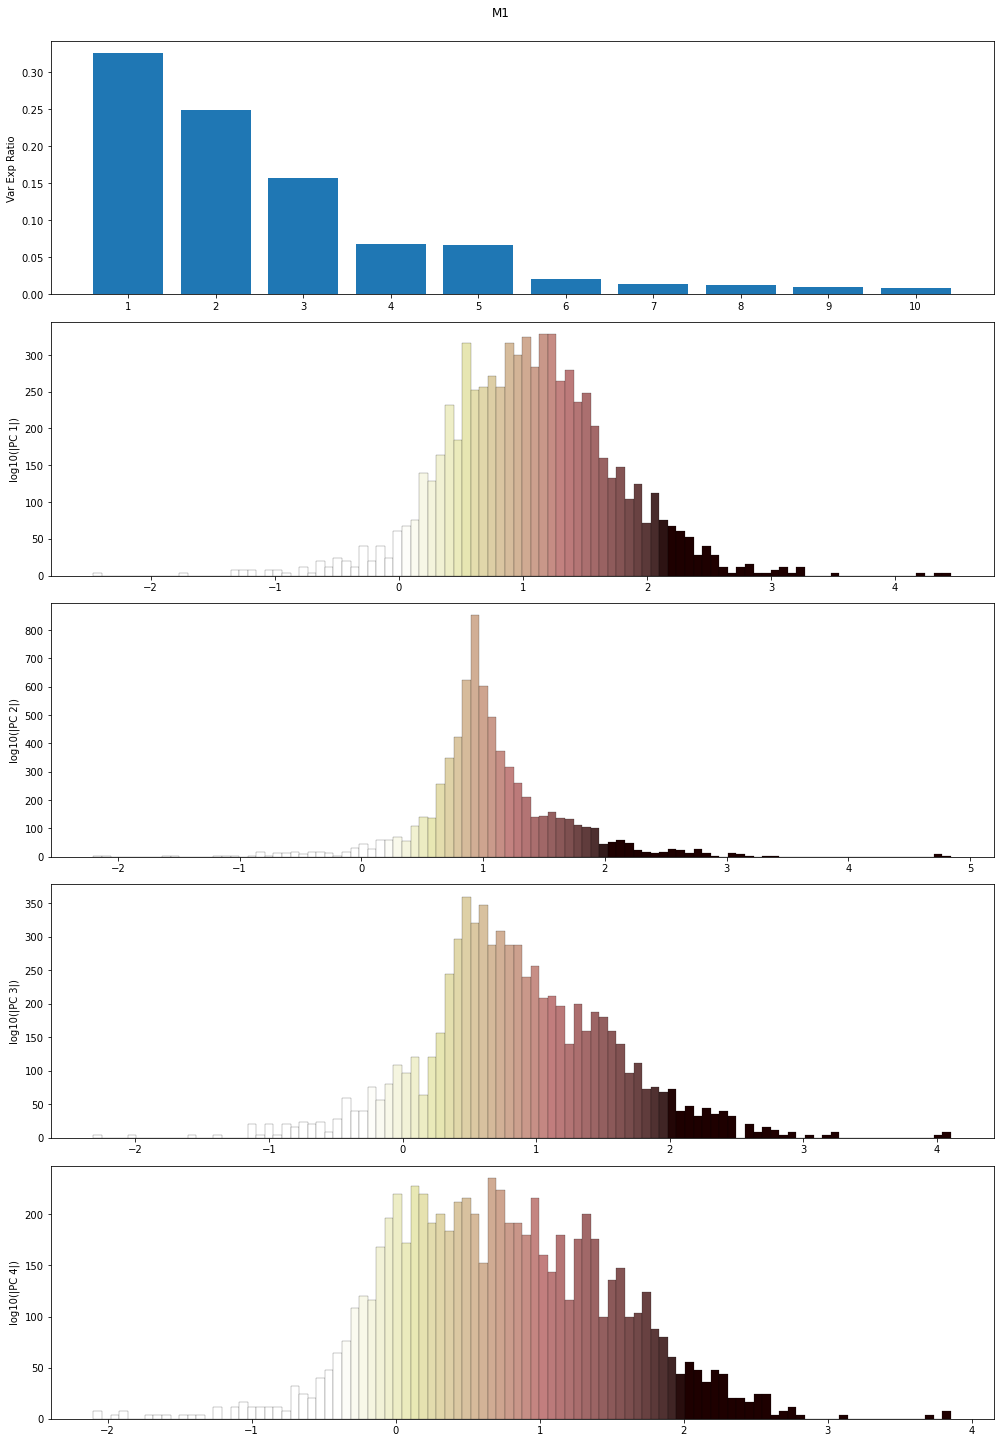

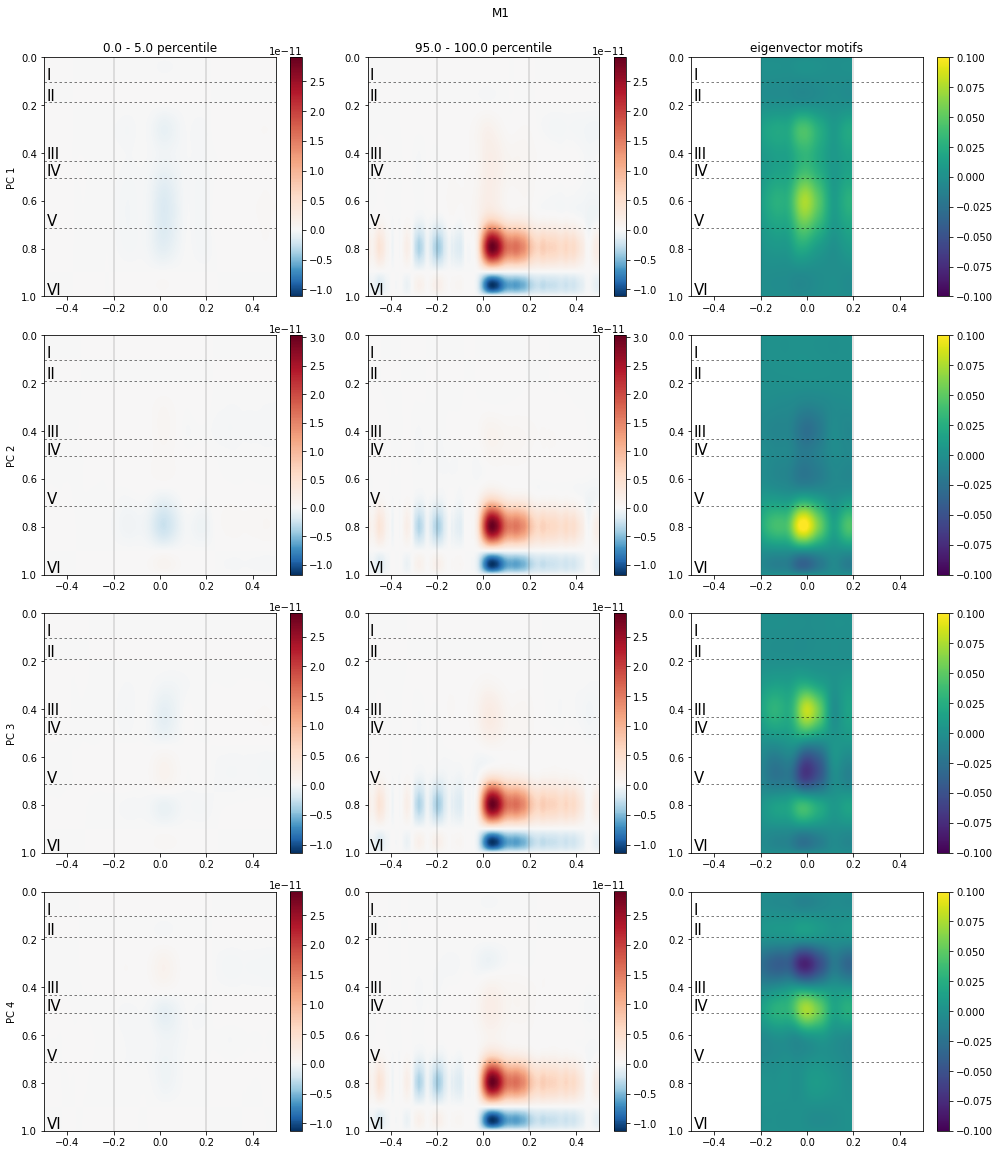

In [365]:
cat = "motor"
data = dataset[cat]
sub = "sub-002"
roi = "M1"
map = (data["subject"] == sub) & (data["roi"] == roi)
outliers_nans = data["nan_map"] | data["outlier_map"]
pca_fit = data["pca_csd"][map & ~outliers_nans]
pca_transform = data["pca_csd"][map & ~data["nan_map"]]

csd = data["csd"][map & ~data["nan_map"]]

scaler.fit(pca_fit)
pca_fit = scaler.transform(pca_fit)
pca.fit(pca_fit)
pca_transform = pca.transform(scaler.transform(pca_transform))
pca_scores, eigenv, exp_var = pca_transform, pca.components_, pca.explained_variance_ratio_

f, ax = plt.subplots(5, 1, figsize=(14, 20), facecolor="white")
ax[0].bar(np.arange(exp_var.shape[0])+1, exp_var)
ax[0].set_xticks(np.arange(exp_var.shape[0])+1)
ax[0].set_ylabel("Var Exp Ratio")

colours_pc = []
for i in range(4):
    pc_abs_log = np.log10(np.abs(pca_scores[:,i]))
    datacolors, mappable = data_to_rgb(
        pc_abs_log, n_bins, "pink_r",
        np.percentile(pc_abs_log, 5),
        np.percentile(pc_abs_log, 95),
        vcenter=np.percentile(pc_abs_log, 50),
        ret_map=True, 
        
    )
    hist, bins, barlist = ax[i+1].hist(pc_abs_log, bins=n_bins, edgecolor='black', linewidth=0.2);
    ax[i+1].set_ylabel("log10(|PC {}|)".format(i+1))
    for _bin_ix, _bin in enumerate(barlist):
        plt.setp(_bin, "facecolor", mappable.to_rgba(bins[_bin_ix+1]))
    plt.suptitle(roi, y=1)
    plt.tight_layout()
filename_template = "/home/mszul/git/DANC_multilayer_laminar/output/{2}/{0}_{1}_PCA_results.{2}"
plt.savefig(filename_template.format(sub, roi, "png"), dpi=300)
plt.savefig(filename_template.format(sub, roi, "svg"))

key_in = [i for i in TOTAL_RESULTS.keys() if sub in i[0]][0]
info = TOTAL_RESULTS[key_in]["info"]
cat_vertices = np.unique(data["ROI_vertices"][map & ~data["nan_map"]])

times, pca_sel, baseline_lim = epoch_types[cat]
pca_time_sel = np.where((times >= pca_sel[0]) & (times <= pca_sel[1]))[0]

prc = np.linspace(0, 100, num=21)
prc_bounds = list(zip(prc[:-1], prc[1:]))
csd_smoothed_pc = []
for pc_comp in range(4):
    pc_sc = pca_scores[:,pc_comp]
    pc_smoothed_csd = []
    for ix, pb in enumerate(prc_bounds):
        bounds = [np.percentile(pc_sc, i) for i in pb]
        pr_mask = np.where((pc_sc >= bounds[0]) & (pc_sc <= bounds[1]))[0]
        mean_smooth_csd = smooth_csd(np.mean(csd[pr_mask], axis=0), info["n_surf"])
        baseline = np.mean(mean_smooth_csd[:, np.where(times < baseline_lim)], axis=2)
        pc_smoothed_csd.append(mean_smooth_csd - baseline)
    pc_smoothed_csd = np.array(pc_smoothed_csd)
    csd_smoothed_pc.append(pc_smoothed_csd)

f, ax = plt.subplots(4, 3, figsize=(14, 4*4), facecolor="white")
ax[0,0].set_title("{} - {} percentile".format(*prc_bounds[0]))
ax[0,1].set_title("{} - {} percentile".format(*prc_bounds[-1]))
ax[0,2].set_title("eigenvector motifs")
for pc_comp in range(4):
    ax[pc_comp,0].set_ylabel("PC {}".format(pc_comp+1))
    vmm = csd_smoothed_pc[pc_comp].min(), csd_smoothed_pc[pc_comp].max()
    data_ = np.array([csd_smoothed_pc[pc_comp][0], csd_smoothed_pc[pc_comp][-1]])
    plot_csd(data_[0], cat_vertices, info["big_brain_layers_path"], times, ax=ax[pc_comp,0], vmin_vmax=vmm)
    plot_csd(data_[1], cat_vertices, info["big_brain_layers_path"], times, ax=ax[pc_comp,1], vmin_vmax=vmm)
    ev = smooth_csd(np.array(np.split(eigenv[pc_comp], info["layers"])), info["layers"])
    nan_ar = np.zeros(data_[0].shape)
    nan_ar[nan_ar == 0] = np.nan
    nan_ar[:, pca_time_sel] = ev
    plot_csd(nan_ar, cat_vertices, info["big_brain_layers_path"], times, ax=ax[pc_comp,2], cmap="viridis")
    for col in range(3):
        ax[pc_comp, col].axvline(times[pca_time_sel][0], lw=0.2, c="black")
        ax[pc_comp, col].axvline(times[pca_time_sel][-1], lw=0.2, c="black")
lab_row = atlas.loc[atlas.USED_LABEL == lab_cats[lab_cat][0]]
plt.suptitle(roi, y=1)
plt.tight_layout()
filename_template = "/home/mszul/git/DANC_multilayer_laminar/output/{2}/{0}_{1}_CSD_results.{2}"
plt.savefig(filename_template.format(sub, roi, "png"), dpi=300)
plt.savefig(filename_template.format(sub, roi, "svg"))